Attribution: Code borrowed from https://github.com/kuangliu/pytorch-cifar

In [1]:
# install required packages
!pip3 install torch
!pip3 install torchvision
!pip3 install torchsummary
!pip3 install matplotlib

In [2]:
# import required packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from models import *
from torchsummary import summary
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [4]:
# hyperparamters to adjust
model = "MobileNetV2"
lr = 0.1
epochs = 200
batch_size = 512
optimizer = "SGD"
has_data_aug = 0

filename = model + "_" + str(lr) + "_" + str(epochs) + "_" + str(batch_size) + "_" + optimizer + "_" + str(has_data_aug)
# Example file format
print(filename)

MobileNetV2_0.1_200_512_SGD_0


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 0

In [6]:
# Data
if has_data_aug:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

0.2%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Model

# net = VGG('VGG19')      20,040,522
# net = ResNet18()        11,173,962
# net = PreActResNet18()  11,171,146
# net = GoogLeNet()        6,166,250
# net = DenseNet121()      6,956,298
# net = ResNeXt29_2x64d()  9,128,778
# net = MobileNet()        3,217,226
# net = MobileNetV2()      2,296,922
# net = DPN92()           34,236,634
# net = ShuffleNetG2()     n/a
# net = SENet18()         11,260,354
# net = ShuffleNetV2(1)    1,263,854
# net = EfficientNetB0()   3,598,598
# net = RegNetX_200MF()    2,321,946
# net = SimpleDLA()       15,142,970

net = MobileNetV2()
# print(net)
# print(summary(net, (3, 32, 32)))

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# commented args logic for notebook
# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.pth')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), correct/total

In [9]:
# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + filename + '.pth')
        best_acc = acc

    return test_loss/len(testloader), correct/total

In [10]:
def plotLoss():
    plt.plot(range(epochs), history['train_loss'], '-', linewidth=3, label='Train Loss')
    plt.plot(range(epochs), history['test_loss'], '-', linewidth=3, label='Test Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [11]:
def plotAcc():
    plt.plot(range(epochs), history['train_acc'], '-', linewidth=3, label='Train Acc')
    plt.plot(range(epochs), history['test_acc'], '-', linewidth=3, label='Test Acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(start_epoch, start_epoch+epochs):

    print('\nEpoch: %d' % epoch)
    train_loss, train_acc = train(epoch)

    print("Train \tLoss: %.3f | Acc: %.3f" % (train_loss, train_acc))

    test_loss, test_acc = test(epoch)
    # print('Test')
    print("Test \tLoss: %.3f | Acc: %.3f" % (test_loss, test_acc))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    scheduler.step()



Epoch: 0
Train 	Loss: 1.687 | Acc: 0.389
Saving..
Test 	Loss: 1.308 | Acc: 0.524

Epoch: 1
Train 	Loss: 1.078 | Acc: 0.611
Saving..
Test 	Loss: 1.018 | Acc: 0.636

Epoch: 2
Train 	Loss: 0.810 | Acc: 0.713
Saving..
Test 	Loss: 0.905 | Acc: 0.694

Epoch: 3
Train 	Loss: 0.634 | Acc: 0.779
Saving..
Test 	Loss: 0.875 | Acc: 0.706

Epoch: 4
Train 	Loss: 0.531 | Acc: 0.814
Saving..
Test 	Loss: 0.722 | Acc: 0.751

Epoch: 5
Train 	Loss: 0.461 | Acc: 0.839
Test 	Loss: 0.739 | Acc: 0.749

Epoch: 6
Train 	Loss: 0.398 | Acc: 0.860
Saving..
Test 	Loss: 0.726 | Acc: 0.759

Epoch: 7
Train 	Loss: 0.359 | Acc: 0.874
Saving..
Test 	Loss: 0.723 | Acc: 0.764

Epoch: 8
Train 	Loss: 0.303 | Acc: 0.893
Saving..
Test 	Loss: 0.721 | Acc: 0.770

Epoch: 9
Train 	Loss: 0.291 | Acc: 0.897
Saving..
Test 	Loss: 0.666 | Acc: 0.793

Epoch: 10
Train 	Loss: 0.276 | Acc: 0.902
Saving..
Test 	Loss: 0.643 | Acc: 0.794

Epoch: 11
Train 	Loss: 0.240 | Acc: 0.916
Test 	Loss: 0.746 | Acc: 0.768

Epoch: 12
Train 	Loss: 0.225 | 

In [ ]:
# save history dict as json

with open("./results/" + filename + ".json", "w") as outfile:
    json.dump(history, outfile)

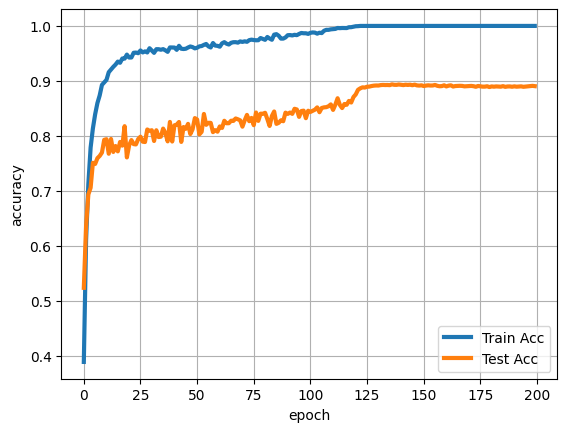

In [ ]:
plotAcc()

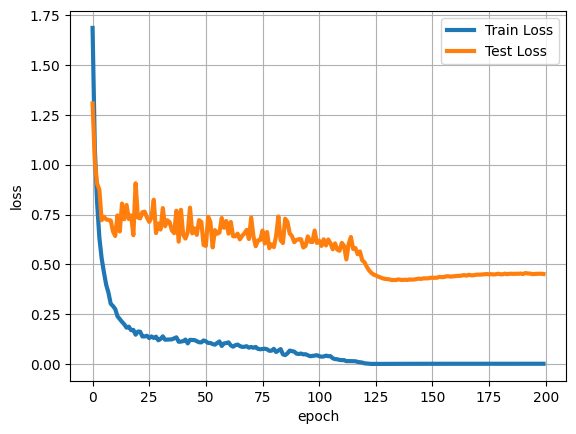

In [ ]:
plotLoss()